# ITPR1
Pathogenic variation in the ITPR1 gene is associated with

[Gillespie syndrome (GLSP)](https://omim.org/entry/206700), 
[spinocerebellar ataxia-15 (SCA15)](https://omim.org/entry/606658), and
[spinocerebellar ataxia-29 (SCA29)](https://omim.org/entry/117360).

Pathological variants associated with SCA29 have been shown to fall into several mechanistic classes.

- R241K, T267M, T267R, R269G, R269W, S277I, K279E, A280D, E497K: Impair IP3 binding to ITPR1 ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- In contrast, V479I, T579I, and N587D did not affect IP3 binding ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Disrupt ITPR1 channel activity without impairing IP3 binding: T579I, N587D ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/))
- Two pathological variants, S1478D and V1538M, are located within the CA8 binding site. V1538M completely abolished CA8 binding. Both variants abolish CA8-mediated suppression of ITPR1 activity ([Ando et al. 2018](https://pubmed.ncbi.nlm.nih.gov/30429331/)). V1538M was identified in an individual with SCA29 and S1478D was found in an individual with ataxic cerebral palsy.


We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
- Suppresor domain (1-223)
- IP3 binding: 226-578
- Regulatory/Coupling: 605-2217
- Channel: 2227-2758 

Three hot-spots for Gillespie syndrome were reported by [McEntagart et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27108798/) Glu2094 missense, Gly2539 missense, and Lys2596 in-frame deletion. 


In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for *ITPR1*.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'ITPR1'
mane_tx_id = 'NM_001378452.1'
mane_protein_id = 'NP_001365381.1' # inositol 1,4,5-trisphosphate receptor type 1 (ITPR1)
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator

cohort_name = "ITPR1"	

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

qc.summarize()

Individuals Processed: 100%|██████████| 170/170 [00:31<00:00,  5.41 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
83,Ataxia
75,Hypotonia
57,Nystagmus
56,Delayed ability to sit
54,Dysarthria
54,Delayed ability to walk
53,Delayed speech and language development
49,Global developmental delay
47,Cerebellar atrophy
32,Dysmetria


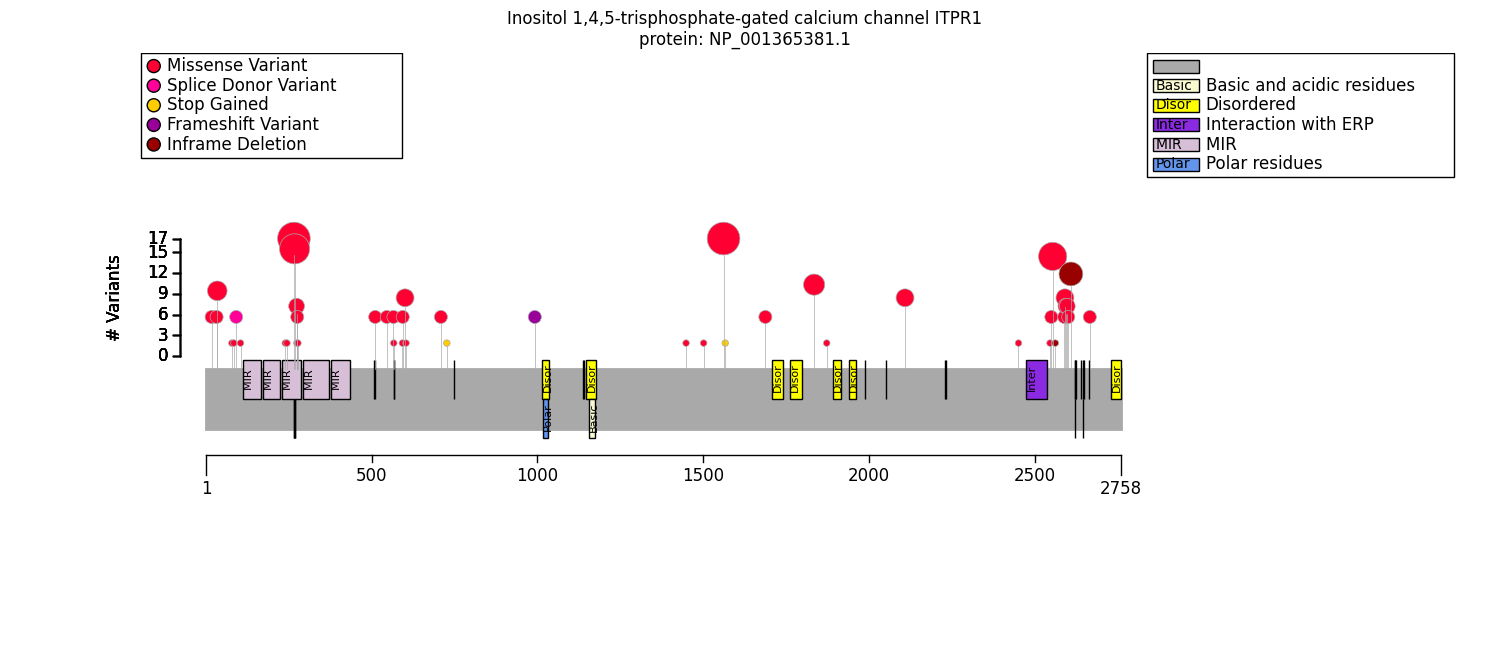

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

itrp1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
itrp1_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
19,SO:1000029_HGNC:6180_ITPR1,SV involving ITPR1 (p.?),,chromosomal deletion
17,3_4706193_4706193_G_A,c.4684G>A (p.Val1562Met),37,missense
14,3_4645673_4645673_C_T,c.800C>T (p.Thr267Met),10,missense
14,3_4645678_4645678_C_T,c.805C>T (p.Arg269Trp),10,missense
10,3_4814521_4814521_G_A,c.7660G>A (p.Gly2554Arg),58,missense
8,3_4815176_4815179_CAGA_C,c.7831_7833del (p.Lys2611del),59,inframe deletion
6,3_4735314_4735314_T_C,c.5504T>C (p.Leu1835Pro),44,missense
5,3_4521037_4521037_C_T,c.106C>T (p.Arg36Cys),4,missense
4,3_4667467_4667467_A_G,c.1804A>G (p.Asn602Asp),18,missense
3,3_4815132_4815132_T_C,c.7781T>C (p.Phe2594Ser),59,missense


# Genotype-Phenotype Correlation (GPC) Analysis

  We will follow [Tolonen et al. (2024)](https://pubmed.ncbi.nlm.nih.gov/37964426/) and divide the sequence encoded by NM_001378452.1 (9908nt; 2758 aa) into 
  
  - Suppresor domain (1-223)
  - IP3 binding: 226-578
  - Regulatory/Coupling: 605-2217
  - Channel: 2227-2758 

The authors state: The distribution of variants across different domains of the IP3R1 protein suggests both loss-of-function (LOF) and gain-of-function (GOF) disease mechanisms (Fig. 2) with important implications for therapeutic development. The majority of SCA29 and GLSP cases harbor variants in the IP3-binding and channel domains.

N-Terminal variants are solely associated with SCA29, while C-terminal variants can cause either GLSP (p.Gly2554Arg and p.Lys2611del) or SCA29.

We will also test structural variants against missense variants for association with SCA15.

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate import variant_key, anyof
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier

# The following variants are at or very near IP3 binding pocket
variant_keys = ('3_4645673_4645673_C_T',  ## p.Thr267Met	
                '3_4645673_4645673_C_G', #p.Thr267Arg
                '3_4645678_4645678_C_T', #	p.Arg269Trp'
                '3_4665283_4665283_A_G',#	p.Tyr567Cys
                '3_4663186_4663186_G_A', #	p.Glu512Lys	missense
                '3_4665285_4665285_A_G',#	p.Arg568Gly	missense
                )
ip3_binding_pocket_vars = anyof(variant_key(key) for key in variant_keys)

ip3_binding_pocket_clf = monoallelic_classifier(
    a_predicate=ip3_binding_pocket_vars,
    b_predicate=~ip3_binding_pocket_vars,
    a_label="IP3 binding",
    b_label="other"
)
ip3_binding_pocket_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=ip3_binding_pocket_clf,
    pheno_clfs=pheno_clfs,
)

mtc_viewer = MtcStatsViewer()
mtc_viewer.process(ip3_binding_pocket_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,64
HMF03,Skipping term because of a child term with the same individual counts,3
HMF08,Skipping general term,77
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,298


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=ip3_binding_pocket_result)

Allele group,IP3 binding,other,Corrected p values,p values
Motor delay [HP:0001270],24/24 (100%),63/89 (71%),0.017097,0.001726
Delayed speech and language development [HP:0000750],13/13 (100%),37/63 (59%),0.017097,0.003070
Neurodevelopmental delay [HP:0012758],29/29 (100%),70/90 (78%),0.017097,0.003258
Nystagmus [HP:0000639],25/26 (96%),53/78 (68%),0.017097,0.003356
Delayed ability to walk [HP:0031936],13/13 (100%),41/68 (60%),0.017097,0.003562
Delayed gross motor development [HP:0002194],18/18 (100%),57/83 (69%),0.021729,0.005432
Delayed ability to sit [HP:0025336],11/11 (100%),42/70 (60%),0.045039,0.013136
Hypotonia [HP:0001252],30/30 (100%),56/65 (86%),0.159657,0.053219
Global developmental delay [HP:0001263],13/16 (81%),35/60 (58%),0.384163,0.144061
Tremor [HP:0001337],18/18 (100%),49/57 (86%),0.447156,0.186315


# Structural variants

In [10]:
from gpsea.analysis.predicate import structural_type

sv_deletion = structural_type('SO:1000029') 
sv_deletion_clf = monoallelic_classifier(a_predicate=sv_deletion, b_predicate=~sv_deletion, a_label="SV Deletion", b_label="other")
sv_deletion_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sv_deletion_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, sv_deletion_result)

Allele group,SV Deletion,other,Corrected p values,p values
Neurodevelopmental delay [HP:0012758],0/19 (0%),99/100 (99%),8.553325e-20,4.073012e-21
Motor delay [HP:0001270],0/19 (0%),87/94 (93%),4.094647e-15,3.899664e-16
Delayed gross motor development [HP:0002194],0/19 (0%),75/82 (91%),2.824803e-14,4.035432e-15
Delayed ability to walk [HP:0031936],0/19 (0%),54/62 (87%),7.223639e-12,1.466040e-12
Delayed speech and language development [HP:0000750],0/19 (0%),50/57 (88%),7.223639e-12,1.719914e-12
Delayed ability to sit [HP:0025336],0/19 (0%),53/62 (85%),1.596355e-11,4.561014e-12
Global developmental delay [HP:0001263],0/19 (0%),48/57 (84%),5.417730e-11,1.805910e-11
Nystagmus [HP:0000639],17/17 (100%),61/87 (70%),1.508824e-02,5.747899e-03
Tremor [HP:0001337],11/11 (100%),56/64 (88%),1.000000e+00,5.949644e-01
Abnormal muscle tone [HP:0003808],1/1 (100%),87/87 (100%),1.000000e+00,1.000000e+00


In [11]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Nystagmus [HP:0000639],34/46 (74%),19/27 (70%),1.0,0.789738
Motor delay [HP:0001270],35/46 (76%),17/22 (77%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],40/46 (87%),23/27 (85%),1.0,1.000000
Cerebellar atrophy [HP:0001272],41/43 (95%),27/28 (96%),1.0,1.000000
Abnormal cerebellum morphology [HP:0001317],44/44 (100%),28/28 (100%),1.0,1.000000
Abnormal metencephalon morphology [HP:0011283],44/44 (100%),28/28 (100%),1.0,1.000000
Abnormal brain morphology [HP:0012443],46/46 (100%),29/29 (100%),1.0,1.000000
Morphological central nervous system abnormality [HP:0002011],47/47 (100%),29/29 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],50/50 (100%),33/33 (100%),1.0,1.000000
Ataxia [HP:0001251],59/59 (100%),37/37 (100%),1.0,1.000000


# Gillespie hotspots
Three hot-spots for Gillespie syndrome were reported by [McEntagart et al. (2016)](https://pubmed.ncbi.nlm.nih.gov/27108798/) Glu2094 missense, Gly2539 missense, and Lys2596 in-frame deletion. 
We map the variants to the MANE select transcript as follows:
- NM_001168272.1:c.6280G>C; NP_001161744.1:p.(Glu2094Gln) = NM_001378452.1:c.6325G>C NP_001365381.1:p.(Glu2109Gln)
- NM_001168272.1:c.7615G>C; NP_001161744.1:p.(Gly2539Arg) = NM_001378452.1:c.7660G>C; NP_001365381.1:p.(Gly2554Arg)
- NM_001168272.2:c.7786_7788del;NP_001161744.1:p.(Lys2596del) = NM_001378452.1:c.7831_7833del; NP_001365381.1:p.(Lys2611del)

In [12]:
E2109K = variant_key("3_4779583_4779583_G_A") # c.6325G>A (p.Glu2109Lys)
E2109Q = variant_key("3_4779583_4779583_G_C") #	c.6325G>C (p.Glu2109Gln)
E2109G = variant_key("3_4779584_4779584_A_G") #	c.6326A>G (p.Glu2109Gly)

G2554Ra = variant_key("3_4814521_4814521_G_C") # c.7660G>C (p.Gly2554Arg)
G2554Rb = variant_key("3_4814521_4814521_G_A") # c.7660G>A (p.Gly2554Arg)
G2554V = variant_key("3_4814522_4814522_G_T") # c.7661G>T (p.Gly2554Val)

K2611del = variant_key("3_4815176_4815179_CAGA_C") # c.7831_7833del (p.Lys2611del)

gillespie_hs_vars = anyof((E2109G, E2109K, E2109Q, G2554Ra, G2554Rb, G2554V, K2611del))

gillespie_hs_clf = monoallelic_classifier(a_predicate=gillespie_hs_vars, b_predicate=~gillespie_hs_vars, a_label="GS Hotspot", b_label="other")
gillespie_hs_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gillespie_hs_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, gillespie_hs_result)


Allele group,GS Hotspot,other,Corrected p values,p values
Aniridia [HP:0000526],14/20 (70%),6/48 (12%),0.000153,0.000006
Delayed ability to sit [HP:0025336],13/13 (100%),40/68 (59%),0.028624,0.003144
Delayed ability to walk [HP:0031936],14/14 (100%),40/67 (60%),0.028624,0.003435
Delayed gross motor development [HP:0002194],18/18 (100%),57/83 (69%),0.030308,0.005432
Motor delay [HP:0001270],19/19 (100%),68/94 (72%),0.030308,0.006062
Delayed speech and language development [HP:0000750],12/13 (92%),38/63 (60%),0.118539,0.028449
Neurodevelopmental delay [HP:0012758],19/19 (100%),80/100 (80%),0.143792,0.040262
Global developmental delay [HP:0001263],8/9 (89%),40/67 (60%),0.444197,0.142143
Nystagmus [HP:0000639],4/4 (100%),74/100 (74%),1.000000,0.569830
Abnormal communication [HP:0034434],13/13 (100%),74/74 (100%),1.000000,1.000000


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fisher_results = (
    GPAnalysisResultSummary.from_multi(
        result=ip3_binding_pocket_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=sv_deletion_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=gillespie_hs_result,
    )
)

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fisher_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                            )

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,IP3 binding,other,p-val,adj. p-val
Delayed speech and language development [HP:0000750],13/13 (100%),37/63 (59%),0.003,0.017
Neurodevelopmental delay [HP:0012758],29/29 (100%),70/90 (78%),0.003,0.017
Delayed gross motor development [HP:0002194],18/18 (100%),57/83 (69%),0.005,0.022
Motor delay [HP:0001270],24/24 (100%),63/89 (71%),0.002,0.017
Nystagmus [HP:0000639],25/26 (96%),53/78 (68%),0.003,0.017
Delayed ability to sit [HP:0025336],11/11 (100%),42/70 (60%),0.013,0.045
Delayed ability to walk [HP:0031936],13/13 (100%),41/68 (60%),0.004,0.017
HPO Term,SV Deletion,other,p-val,adj. p-val
Delayed speech and language development [HP:0000750],0/19 (0%),50/57 (88%),1.72e-12,7.22e-12
Neurodevelopmental delay [HP:0012758],0/19 (0%),99/100 (99%),4.07e-21,8.55e-20


In [15]:
summarizer.process_latex(report=report, protein_fig=itrp1_fig)

Figure saved to ../../supplement/img/ITPR1_protein_diagram-draft.pdf
Output to ../../supplement/tex/ITPR1_summary_draft.tex
